In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('categorized_data.csv')

## Michael's Work (we can decide if this is the best way to handle it later)

/home/upw4ys/Documents/.conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



       MODEL STATISTICS       

Model Accuracy: 0.4773

Classification Report:

                  precision    recall  f1-score   support

  Extreme Change       0.45      0.33      0.38       928
 Moderate Change       0.46      0.49      0.47       919
No/Little Change       0.51      0.61      0.56       881

        accuracy                           0.48      2728
       macro avg       0.47      0.48      0.47      2728
    weighted avg       0.47      0.48      0.47      2728


Top 10 Predictors for 'Extreme Change':
species_P mariana         0.505968
avg_solar_irradiance      0.311792
plot_6                    0.297113
plot_3                    0.198441
site_AK                   0.139052
avg_soil_water_content    0.107719
average_air_pressure      0.098568
freeze_flag_1             0.094071
plot_4                    0.070498
freeze_flag_0             0.044897
dtype: float64



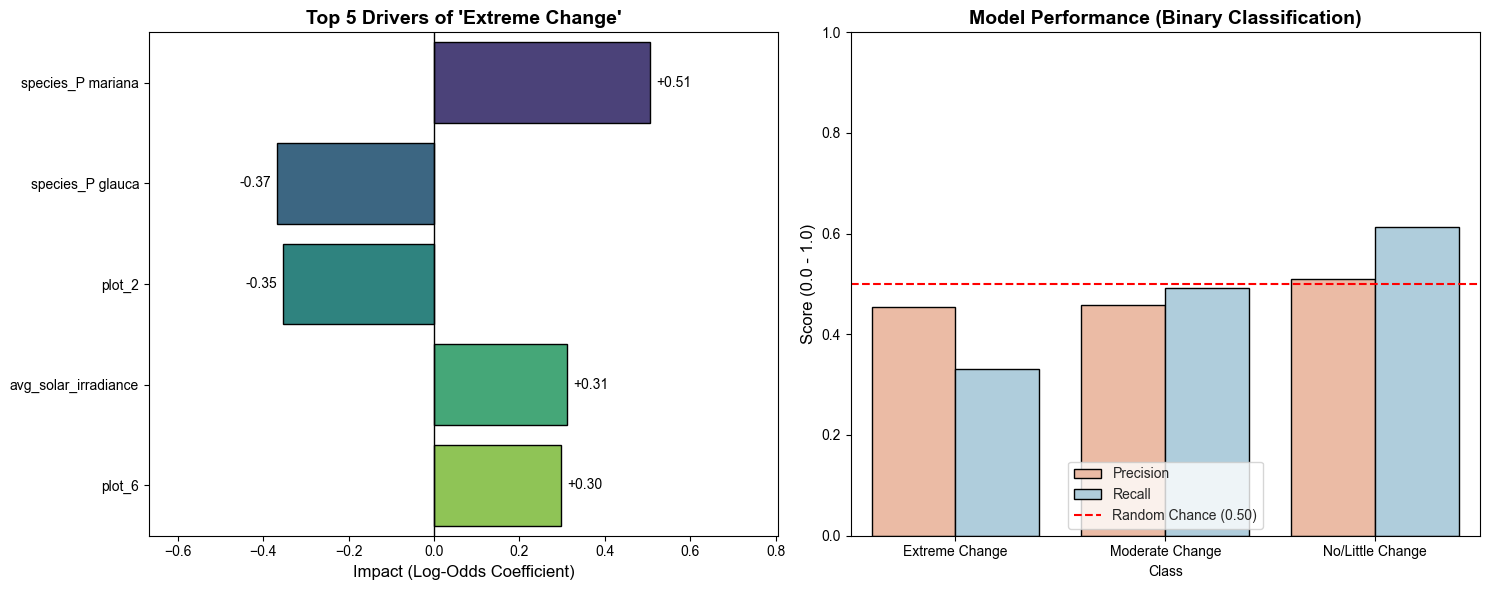

In [4]:
target = 'growth_category'

numeric_features = [
    'average_humidity', 
    'avg_solar_irradiance', 
    'avg_soil_water_content',
    'average_air_pressure'
]


categorical_features = ['freeze_flag','species', 'site', 'plot']

X = df[numeric_features + categorical_features]
y = df[target]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) 
])


categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


model.fit(X_train, y_train)

cat_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_feature_names)



target_class = 'Extreme Change'
if hasattr(model.named_steps['classifier'], 'coef_'):
    coefs = model.named_steps['classifier'].coef_
    
    if coefs.shape[0] == 1:
        positive_class = model.classes_[1]
        raw_coefs = coefs[0]
        
        if positive_class == target_class:
            coefficients = raw_coefs
        else:
            coefficients = -raw_coefs
    else:
        class_index = list(model.classes_).index(target_class)
        coefficients = coefs[class_index]


df_coef = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
df_coef = df_coef.reindex(df_coef.Coefficient.abs().sort_values(ascending=False).index).head(5)

y_pred = model.predict(X_test)
report_dict = classification_report(y_test, y_pred, output_dict=True)


classes_to_plot = [c for c in model.classes_ if c in report_dict and c != 'accuracy']

perf_data = {
    'Class': classes_to_plot,
    'Precision': [report_dict[c]['precision'] for c in classes_to_plot],
    'Recall':    [report_dict[c]['recall'] for c in classes_to_plot]
}
df_perf = pd.DataFrame(perf_data)
df_perf_melted = df_perf.melt(id_vars='Class', var_name='Metric', value_name='Score')


print("\n" + "="*30)
print("       MODEL STATISTICS       ")
print("="*30)

print(f"\nModel Accuracy: {model.score(X_test, y_test):.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print(f"\nTop 10 Predictors for '{target_class}':")
coef_series = pd.Series(coefficients, index=feature_names)
print(coef_series.sort_values(ascending=False).head(10))
print("\n" + "="*30)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.set_style("whitegrid")

sns.barplot(
    x='Coefficient', 
    y='Feature', 
    hue='Feature',
    data=df_coef, 
    ax=axes[0], 
    palette='viridis', 
    edgecolor='black',
    legend=False
)
axes[0].set_title(f"Top 5 Drivers of '{target_class}'", fontsize=14, weight='bold')
axes[0].set_xlabel("Impact (Log-Odds Coefficient)", fontsize=12)
axes[0].set_ylabel("")
axes[0].axvline(0, color='black', linewidth=1)

min_coef = df_coef['Coefficient'].min()
max_coef = df_coef['Coefficient'].max()
padding = max(0.3, (max_coef - min_coef) * 0.2)
axes[0].set_xlim(min_coef - padding, max_coef + padding)

for i, v in enumerate(df_coef['Coefficient']):
    offset = padding * 0.05
    axes[0].text(
        v + (offset if v > 0 else -offset), 
        i, 
        f"{v:+.2f}", 
        va='center', 
        ha='left' if v > 0 else 'right',
        fontsize=10, 
        color='black'
    )

sns.barplot(
    x='Class', 
    y='Score', 
    hue='Metric', 
    data=df_perf_melted, 
    ax=axes[1], 
    palette='RdBu', 
    edgecolor='black'
)
axes[1].set_title("Model Performance (Binary Classification)", fontsize=14, weight='bold')
axes[1].set_ylim(0, 1.0)
axes[1].set_ylabel("Score (0.0 - 1.0)", fontsize=12)
axes[1].axhline(0.5, color='red', linestyle='--', label='Random Chance (0.50)')
axes[1].legend(loc='lower center')

plt.tight_layout()
plt.show()


# Logistic Regression

To address the research question of distinguishing distinct physiological regimes, we utilized a multinomial logistic regression classifier to predict categories of Basal Area Daily Amplitude, a choice well-justified for isolating "Extreme Change" events from background noise. The model achieved an accuracy of 47.7%, outperforming the random baseline (33%), though performance metrics indicate a stronger ability to identify stable periods ("No/Little Change" Recall: 0.61) compared to detecting high-amplitude events ("Extreme Change" Recall: 0.33). Despite this identification gap, the model successfully validated key biological assumptions, confirming that species identity and energy input are deterministic: Picea mariana and high average solar irradiance emerged as the strongest positive drivers of extreme daily amplitude, while Picea glauca served as a significant negative predictor associated with stability.